Chest X-Ray Images 데이터셋(https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) 을 이용해 폐렴 검출하는 모델을 만들고 성능을 검증하세요.

코드 작성 내용
1.	CNN 모델(2개 이상)을 이용한 정상/폐렴 분류
2.	분류 결과에 대한 CAM 그리기
3.	각 모델 별 데이터 증강 유/무에 따른 성능 검증
4.	CNN 모델 간 성능 비교 검증

In [ ]:
!pip install tensorflow keras opencv-python matplotlib

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## 데이터 로드

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

data_dir = '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/기말고사/chest_xray'  # 데이터셋 경로 수정 필요

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    data_dir + '/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir + '/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    data_dir + '/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## CNN 모델 정의

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, GlobalAveragePooling2D

# GoogLeNet
def inception_module(x, filters):
    # 1x1 conv
    conv1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(x)

    # 1x1 conv followed by 3x3 conv
    conv3 = Conv2D(filters=filters[1], kernel_size=(1, 1), padding='same', activation='relu')(x)
    conv3 = Conv2D(filters=filters[2], kernel_size=(3, 3), padding='same', activation='relu')(conv3)

    # 1x1 conv followed by 5x5 conv
    conv5 = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(x)
    conv5 = Conv2D(filters=filters[4], kernel_size=(5, 5), padding='same', activation='relu')(conv5)

    # 3x3 max pooling followed by 1x1 conv
    pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(filters=filters[5], kernel_size=(1, 1), padding='same', activation='relu')(pool)

    # concatenate filters
    out = Concatenate(axis=-1)([conv1, conv3, conv5, pool])
    return out

def GoogLeNet(input_shape):
    inputs = Input(input_shape)

    x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32]) # Inception 3a
    x = inception_module(x, [128, 128, 192, 32, 96, 64]) # Inception 3b
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x) # 이진 분류를 위한 출력 레이어

    model = Model(inputs, x)
    return model

In [ ]:
# DenseNet
def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x = conv_block(x, growth_rate)
    return x

def transition_layer(x, reduction):
    x = BatchNormalization()(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), 1, activation='relu', padding='same')(x)
    x = AveragePooling2D(2, strides=2, padding='same')(x)
    return x

def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Conv2D(4 * growth_rate, (1, 1), activation='relu', padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(growth_rate, (3, 3), activation='relu', padding='same')(x1)
    x = Concatenate(axis=-1)([x, x1])
    return x

def DenseNet(input_shape, blocks):
    inputs = Input(input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    for block in blocks:
        x = dense_block(x, block, 32)
        x = transition_layer(x, 0.5)

    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)  # 이진 분류를 위한 출력 레이어

    model = Model(inputs, x)
    return model


In [ ]:
# 모델 컴파일 및 학습 함수
def compile_and_train(model, train_generator, validation_generator, epochs=20):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
    validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )
    return history

input_shape = (150, 150, 3)  # 이미지 크기와 채널

# GoogLeNet 모델 학습
googlenet = GoogLeNet(input_shape)
googlenet_history = compile_and_train(googlenet, train_generator, validation_generator)

# DenseNet 모델 학습
blocks = [6, 12, 24, 16]  # DenseNet의 블록 구성
densenet = DenseNet(input_shape, blocks)
densenet_history = compile_and_train(densenet, train_generator, validation_generator)

Epoch 1/20
163/163 [==============================] - 847s 5s/step - loss: 0.3718 - accuracy: 0.8305 - val_loss: 2.8780 - val_accuracy: 0.5000
Epoch 2/20
163/163 [==============================] - 53s 324ms/step - loss: 0.1712 - accuracy: 0.9321 - val_loss: 1.8070 - val_accuracy: 0.5000
Epoch 3/20
163/163 [==============================] - 54s 328ms/step - loss: 0.1025 - accuracy: 0.9626 - val_loss: 4.8529 - val_accuracy: 0.5000
Epoch 4/20
163/163 [==============================] - 53s 326ms/step - loss: 0.0982 - accuracy: 0.9622 - val_loss: 1.6376 - val_accuracy: 0.6875
Epoch 5/20
163/163 [==============================] - 53s 326ms/step - loss: 0.0832 - accuracy: 0.9707 - val_loss: 0.9518 - val_accuracy: 0.6250
Epoch 6/20
163/163 [==============================] - 53s 326ms/step - loss: 0.0611 - accuracy: 0.9751 - val_loss: 1.3983 - val_accuracy: 0.6875
Epoch 7/20
163/163 [==============================] - 53s 325ms/step - loss: 0.0562 - accuracy: 0.9793 - val_loss: 0.3377 - val_accu

In [ ]:
# 모델 성능 검증 함수
def evaluate_model(model, test_generator):
    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

# GoogLeNet 모델 성능 검증
evaluate_model(googlenet, test_generator)

# DenseNet 모델 성능 검증
evaluate_model(densenet, test_generator)

19/19 [==============================] - 127s 7s/step - loss: 1.4724 - accuracy: 0.6562
Test accuracy: 0.65625, Test loss: 1.4724119901657104
19/19 [==============================] - 6s 297ms/step - loss: 2.6287 - accuracy: 0.4803
Test accuracy: 0.4802631437778473, Test loss: 2.6287262439727783


## 분류에 대한 CAM 그리기

In [ ]:
for layer in googlenet.layers:
    print(layer.name)

input_1
conv2d
max_pooling2d
batch_normalization
conv2d_1
max_pooling2d_1
conv2d_3
conv2d_5
max_pooling2d_2
conv2d_2
conv2d_4
conv2d_6
conv2d_7
concatenate
conv2d_9
conv2d_11
max_pooling2d_3
conv2d_8
conv2d_10
conv2d_12
conv2d_13
concatenate_1
max_pooling2d_4
global_average_pooling2d
dense
dense_1


In [ ]:
for layer in densenet.layers:
    print(layer.name)

input_2
conv2d_14
max_pooling2d_5
batch_normalization_1
conv2d_15
batch_normalization_2
conv2d_16
concatenate_2
batch_normalization_3
conv2d_17
batch_normalization_4
conv2d_18
concatenate_3
batch_normalization_5
conv2d_19
batch_normalization_6
conv2d_20
concatenate_4
batch_normalization_7
conv2d_21
batch_normalization_8
conv2d_22
concatenate_5
batch_normalization_9
conv2d_23
batch_normalization_10
conv2d_24
concatenate_6
batch_normalization_11
conv2d_25
batch_normalization_12
conv2d_26
concatenate_7
batch_normalization_13
conv2d_27
average_pooling2d
batch_normalization_14
conv2d_28
batch_normalization_15
conv2d_29
concatenate_8
batch_normalization_16
conv2d_30
batch_normalization_17
conv2d_31
concatenate_9
batch_normalization_18
conv2d_32
batch_normalization_19
conv2d_33
concatenate_10
batch_normalization_20
conv2d_34
batch_normalization_21
conv2d_35
concatenate_11
batch_normalization_22
conv2d_36
batch_normalization_23
conv2d_37
concatenate_12
batch_normalization_24
conv2d_38
batch_no

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# CAM 생성 함수 정의
def generate_cam(model, layer_name, img_array, class_index):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()

    cam = np.maximum(cam, 0)
    if cam.max() != 0:
        cam = cam / cam.max()  # Normalize
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))

    return cam

In [ ]:
# CAM 시각화 함수
def display_cam(image_path, cam):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (cam.shape[1], cam.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img)
    overlay = overlay / np.max(overlay)
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

In [ ]:
# 클래스 이름 확인
print("클래스 인덱스 (train):", train_generator.class_indices)
print("클래스 인덱스 (validation):", validation_generator.class_indices)
print("클래스 인덱스 (test):", test_generator.class_indices)

클래스 인덱스 (train): {'NORMAL': 0, 'PNEUMONIA': 1}
클래스 인덱스 (validation): {'NORMAL': 0, 'PNEUMONIA': 1}
클래스 인덱스 (test): {'NORMAL': 0, 'PNEUMONIA': 1}


1/1 [==============================] - 0s 22ms/step
GoogLeNet 모델이 이 이미지를 NORMAL로 분류했습니다.


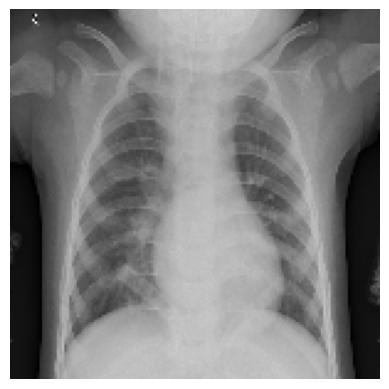

1/1 [==============================] - 0s 33ms/step
DenseNet 모델이 이 이미지를 NORMAL로 분류했습니다.


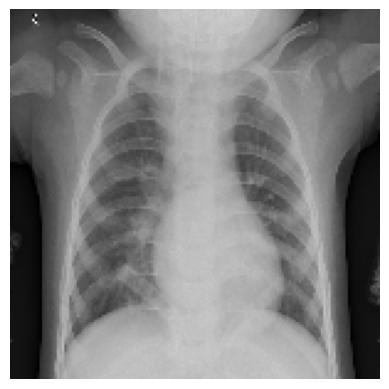

In [ ]:
# PNEUMONIA 예제 이미지 경로
p_img_path = '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/기말고사/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg'

# 이미지를 모델 입력 형식에 맞게 전처리
img = image.load_img(p_img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 클래스 이름 정의 (0: NORMAL, 1: PNEUMONIA)
class_names = ['NORMAL', 'PNEUMONIA']

# GoogLeNet 모델 예측 및 CAM 생성
class_index = np.argmax(googlenet.predict(img_array))
googlenet_class_name = class_names[class_index]
print(f'GoogLeNet 모델이 이 이미지를 {googlenet_class_name}로 분류했습니다.')
cam = generate_cam(googlenet, 'conv2d_13', img_array, class_index)
display_cam(p_img_path, cam)

# DenseNet 모델 예측 및 CAM 생성
class_index = np.argmax(densenet.predict(img_array))
densenet_class_name = class_names[class_index]
print(f'DenseNet 모델이 이 이미지를 {densenet_class_name}로 분류했습니다.')
cam = generate_cam(densenet, 'conv2d_134', img_array, class_index)
display_cam(p_img_path, cam)

1/1 [==============================] - 0s 24ms/step
GoogLeNet 모델이 이 이미지를 NORMAL로 분류했습니다.


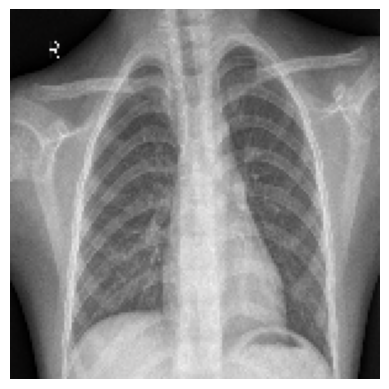

1/1 [==============================] - 0s 37ms/step
DenseNet 모델이 이 이미지를 NORMAL로 분류했습니다.


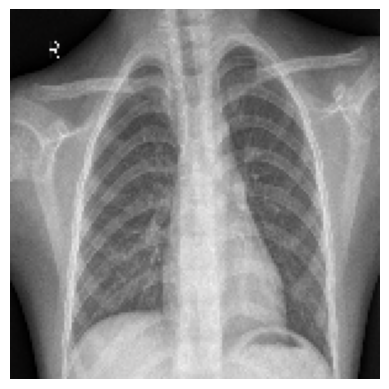

In [ ]:
# NORMAL 예제 이미지 경로
n_img_path = '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/기말고사/chest_xray/test/NORMAL/IM-0023-0001.jpeg'

# 이미지를 모델 입력 형식에 맞게 전처리
img = image.load_img(n_img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 클래스 이름 정의 (0: NORMAL, 1: PNEUMONIA)
class_names = ['NORMAL', 'PNEUMONIA']

# GoogLeNet 모델 예측 및 CAM 생성
class_index = np.argmax(googlenet.predict(img_array))
googlenet_class_name = class_names[class_index]
print(f'GoogLeNet 모델이 이 이미지를 {googlenet_class_name}로 분류했습니다.')
cam = generate_cam(googlenet, 'conv2d_13', img_array, class_index)
display_cam(n_img_path, cam)

# DenseNet 모델 예측 및 CAM 생성
class_index = np.argmax(densenet.predict(img_array))
densenet_class_name = class_names[class_index]
print(f'DenseNet 모델이 이 이미지를 {densenet_class_name}로 분류했습니다.')
cam = generate_cam(densenet, 'conv2d_134', img_array, class_index)
display_cam(n_img_path, cam)

## 각 모델 별 데이터 증강 유/무에 따른 성능 검증하기

In [ ]:
# 데이터 증강을 사용한 학습 데이터 생성기
augmented_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_train_generator = augmented_train_datagen.flow_from_directory(
    data_dir + '/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [ ]:
# GoogLeNet 모델 학습과 평가 (데이터 증강 사용)
googlenet_history_aug = compile_and_train(googlenet, augmented_train_generator, validation_generator)
evaluate_model(googlenet, test_generator)

Epoch 1/20
163/163 [==============================] - 88s 509ms/step - loss: 0.2335 - accuracy: 0.9013 - val_loss: 1.2697 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 81s 497ms/step - loss: 0.1886 - accuracy: 0.9231 - val_loss: 0.9223 - val_accuracy: 0.6875
Epoch 3/20
163/163 [==============================] - 85s 523ms/step - loss: 0.1819 - accuracy: 0.9264 - val_loss: 0.6748 - val_accuracy: 0.7500
Epoch 4/20
163/163 [==============================] - 81s 499ms/step - loss: 0.1732 - accuracy: 0.9296 - val_loss: 1.0791 - val_accuracy: 0.6875
Epoch 5/20
163/163 [==============================] - 82s 501ms/step - loss: 0.1519 - accuracy: 0.9423 - val_loss: 2.4565 - val_accuracy: 0.5625
Epoch 6/20
163/163 [==============================] - 82s 500ms/step - loss: 0.1449 - accuracy: 0.9436 - val_loss: 0.3688 - val_accuracy: 0.8750
Epoch 7/20
163/163 [==============================] - 81s 499ms/step - loss: 0.1370 - accuracy: 0.9469 - val_loss: 1.7703 - val_ac

In [ ]:
# DenseNet 모델 학습과 평가 (데이터 증강 사용)
densenet_history_aug = compile_and_train(densenet, augmented_train_generator, validation_generator)
evaluate_model(densenet, test_generator)

Epoch 1/20
163/163 [==============================] - 157s 517ms/step - loss: 0.2279 - accuracy: 0.9110 - val_loss: 1.1721 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 83s 505ms/step - loss: 0.1744 - accuracy: 0.9333 - val_loss: 1.9309 - val_accuracy: 0.5625
Epoch 3/20
163/163 [==============================] - 83s 510ms/step - loss: 0.1632 - accuracy: 0.9358 - val_loss: 14.6353 - val_accuracy: 0.5000
Epoch 4/20
19/19 [==============================] - 6s 315ms/step - loss: 1.6001 - accuracy: 0.6447
Test accuracy: 0.6447368264198303, Test loss: 1.6000794172286987


In [ ]:
from tensorflow.keras.applications import DenseNet121
# DenseNet 모델 정의
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# 모델 커스터마이징
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)  # 이진 분류를 가정하고 있음
densenet_aug = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# 모델 컴파일 (이미 올바르게 되어 있음)
googlenet_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
densenet_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 성능 검증 함수
def evaluate_model(model, test_generator):
    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

# GoogLeNet 모델 성능 검증
evaluate_model(googlenet_aug, test_generator)

# DenseNet 모델 성능 검증
evaluate_model(densenet_aug, test_generator)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - 6s 313ms/step - loss: 0.0000e+00 - accuracy: 0.3750
Test accuracy: 0.375, Test loss: 0.0
19/19 [==============================] - 11s 293ms/step - loss: 0.0000e+00 - accuracy: 0.6250
Test accuracy: 0.625, Test loss: 0.0


## CNN 모델 간 성능 비교 검증

In [ ]:
for layer in googlenet_aug.layers:
    print(layer.name)

input_4
conv2d_149
max_pooling2d_11
batch_normalization_123
conv2d_150
max_pooling2d_12
conv2d_152
conv2d_154
max_pooling2d_13
conv2d_151
conv2d_153
conv2d_155
conv2d_156
concatenate_62
conv2d_158
conv2d_160
max_pooling2d_14
conv2d_157
conv2d_159
conv2d_161
conv2d_162
concatenate_63
max_pooling2d_15
global_average_pooling2d_3
dense_5
dense_6


In [ ]:
for layer in densenet_aug.layers:
    print(layer.name)

input_7
zero_padding2d_4
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_5
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3

1/1 [==============================] - 0s 20ms/step
GoogLeNet 모델이 이 이미지를 NORMAL로 분류했습니다.


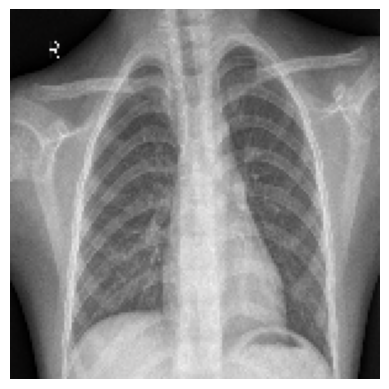

1/1 [==============================] - 3s 3s/step
DenseNet 모델이 이 이미지를 NORMAL로 분류했습니다.


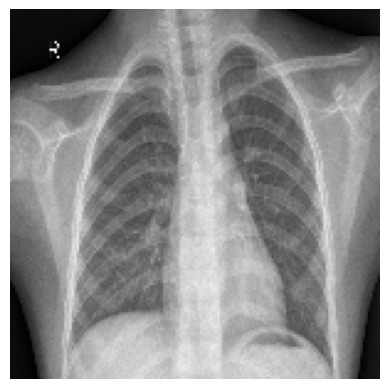

In [ ]:
# NORMAL 예제 이미지 경로
n_img_path = '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/기말고사/chest_xray/test/NORMAL/IM-0023-0001.jpeg'

# 이미지를 모델 입력 형식에 맞게 전처리
img = image.load_img(n_img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 클래스 이름 정의 (0: NORMAL, 1: PNEUMONIA)
class_names = ['NORMAL', 'PNEUMONIA']

# GoogLeNet 모델 예측 및 CAM 생성
class_index = np.argmax(googlenet_aug.predict(img_array))
googlenet_aug_class_name = class_names[class_index]
print(f'GoogLeNet 모델이 이 이미지를 {googlenet_aug_class_name}로 분류했습니다.')
cam = generate_cam(googlenet_aug, 'conv2d_162', img_array, class_index)
display_cam(n_img_path, cam)

# DenseNet 모델 예측 및 CAM 생성
class_index = np.argmax(densenet_aug.predict(img_array))
densenet_aug_class_name = class_names[class_index]
print(f'DenseNet 모델이 이 이미지를 {densenet_aug_class_name}로 분류했습니다.')
cam = generate_cam(densenet_aug, 'conv5_block16_2_conv', img_array, class_index)
display_cam(n_img_path, cam)